In [0]:
import os
os.chdir('./drive/My Drive/predict-wearer')

In [0]:
from utilize.data import *
from utilize.model import *
import tensorflow.keras as keras
import numpy as np

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

# Dataset

In [0]:
DATA_PATH = "./data/002_0528.wav"
LABELS_PATH = "./data/002_0528.txt"

In [0]:
X, y, sr = load_full_frame(data_path = DATA_PATH, labels_path = LABELS_PATH, sr = 8000)

In [27]:
print("Loat the dataset with 8000 Hz sample rate")
print("Total length: %.2fmin\tWearer speech: %.2f%%\tOthers speech: %.2f%%" 
      %(X.shape[0]/sr/60, np.sum(y[:, 0])/y[:, 0].shape[0]*100, np.sum(y[:, 1])/y[:, 1].shape[0]*100))

Loat the dataset with 8000 Hz sample rate
Total length: 89.08min	Wearer speech: 15.98%	Others speech: 13.38%


In [0]:
labels = pd.read_csv(LABELS_PATH, sep='\t', header=None,
                    names=['start', 'end', 'annotation'],
                    dtype=dict(start=float,end=float,annotation=str))

In [0]:
w_len = np.array(labels.loc[labels['annotation'] == 'W', 'end']) - np.array(labels.loc[labels['annotation'] == 'W', 'start'])

In [0]:
o_len = np.array(labels.loc[labels['annotation'] == 'O', 'end']) - np.array(labels.loc[labels['annotation'] == 'O', 'start'])

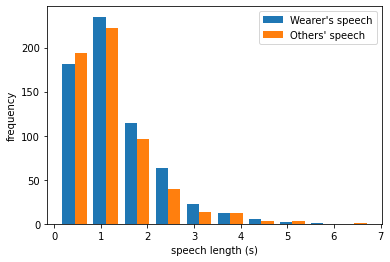

In [37]:
plt.hist([w_len, o_len])
plt.legend(["Wearer's speech", "Others' speech"])
plt.xlabel("speech length (s)")
plt.ylabel("frequency")
plt.show()

## Preprocessing 
* Segment the data into 256 length frames, which corresponds to 32 ms 
* Use the label of the last time step in a frame as the true ground
* Drop the frame without speech and both wearer's and others' speech
* Normalize each frame to zero mean and unit std 

In [0]:
X, y, sr = load_frames(data_path = DATA_PATH, labels_path = LABELS_PATH, sr = 8000, frame_length = 256)

In [0]:
print(X.shape, y.shape, sr)
print("Load %d frames of a time step length %d corrsponding to %dms per frame" %(X.shape[0], X.shape[1], X.shape[1]/sr*1000))

(48745, 256, 1) (48745,) 8000
Load 48745 frames of a time step length 256 corrsponding to 32ms per frame


In [0]:
X_normal = (X - np.mean(X, axis = 1, keepdims = True)) / np.std(X, axis = 1, keepdims = True)
print(X_normal.shape)

(48745, 256, 1)


## MFCC feature extreaction 

In [0]:
X, y, sr = load_full_frame(sr = 16000)

In [0]:
mfcc_14 = librosa.feature.mfcc(X, sr = sr, n_mfcc = 14, n_fft = 960, hop_length = 160)

In [9]:
mfcc_14.shape, X.shape

((14, 198052), (31688223,))

In [0]:
mfcc_delta_1 = librosa.feature.delta(mfcc_14)
mfcc_delta_2 = librosa.feature.delta(mfcc_delta_1)

In [12]:
mfcc_delta_1.shape, mfcc_delta_2.shape

((14, 198052), (14, 198052))

In [0]:
y_prime = []
for label in y: 
    if label[0] and not label[1]: 
        y_prime.append(1)
    elif label[1] and not label[0]:
        y_prime.append(0)
    else: 
        y_prime.append(-1)

y_prime = np.array(y_prime)

In [16]:
np.unique(y_prime, return_counts=True)

(array([-1,  0,  1]), array([18632699,  7125451,  5930073]))

In [0]:
y_frames = librosa.util.frame(y_prime, frame_length = 960, hop_length = 160)

In [23]:
y_frames.shape, y_prime.shape

((960, 198046), (31688223,))

# Problems about the network in the paper 

This deep learning model starts with Convolutional Autoencoder (Encoder: 3 convolution layers, 3 MaxPooling layers and one fully-connected layer; Decoder: 3 convolution layers, 3 up-sampling layers and one fully-connected layer) followed by 3 layers of BLSTM, then 4 layers of LSTMs, and finally the softmax layer. All LSTM layers use the hyperbolic tangent as the activation function. The training algorithm for all layers is the Adam algorithm (4). The learning rate used is 10-5, and the regularisers used are dropout, batch normalisation, and l2 regularization. The classifier is trained only on the wearer speech and speech of other speakers from the training dataset (i.e. non-speech was not included in the training).  

* Kernal size 1 make sense?
* No fully-connected layer in source code
* learning rate 10 - 5 will easily diverge
* Use the prediction of the last time step as the prediction of the whole frame? 
* 256 steps (32 ms) seems too short to make the prediction 

## Code for WearerModel 
I followed the model described in the paper (code as following), and trained the model on my dataset (lr = 0.01, higher value will diverge). The loss didn't go down at all and prediction became exactly the ratios of two classes. 

In [0]:
class WearerModel(Model):

    def __init__(self, frame_length = 256, num_channels = 1, p = 0.5, regularization = 0.0005):

        super(WearerModel, self).__init__()

        self.frame_length = frame_length
        self.num_channels = num_channels
        self.dropout = p
        self.regularization = regularization

        ## conv autoencoder
        # encoder conv1
        self.conv1 = Conv1D(100, kernel_size = 1, activation = 'relu', input_shape = (frame_length, num_channels))
        self.maxpool1 = MaxPool1D(pool_size = 2)
        # encoder conv2
        self.conv2 = Conv1D(100, kernel_size = 1, activation = 'relu')
        self.maxpool2 = MaxPool1D(pool_size = 2)
        # encoder conv3
        self.conv3 = Conv1D(100, kernel_size = 1, activation = 'relu')
        self.maxpool3 = MaxPool1D(pool_size = 4)
        # decoder conv1
        self.deconv1 = Conv1D(100, kernel_size = 1, activation = 'relu')
        self.upsampling1 = UpSampling1D(size = 4)
        # decoder conv2
        self.deconv2 = Conv1D(100, kernel_size = 1, activation = 'relu')
        self.upsampling2 = UpSampling1D(size = 2)
        # decoder conv3
        self.deconv3 = Conv1D(100, kernel_size = 1, activation = 'relu')
        self.upsampling3 = UpSampling1D(size = 2)
        # one fully-connected layer
        self.dense0 = Dense(1, activation = 'relu')
        self.conv_dropout = Dropout(p)

        ## three layers of bidirectional lstm
        self.bilstm1 = Bidirectional(LSTM(128, dropout=p, return_sequences=True))
        self.bilstm2 = Bidirectional(LSTM(128, dropout=p, return_sequences=True))
        self.bilstm3 = Bidirectional(LSTM(128, dropout=p, return_sequences=True))

        ## four layers of lstm
        self.lstm1 = LSTM(128, dropout=p, kernel_regularizer=regularizers.l2(regularization), return_sequences=True)
        self.lstm2 = LSTM(128, dropout=p, kernel_regularizer=regularizers.l2(regularization), return_sequences=True)
        self.lstm3 = LSTM(128, dropout=p, kernel_regularizer=regularizers.l2(regularization), return_sequences=True)
        self.lstm4 = LSTM(128, dropout=p, kernel_regularizer=regularizers.l2(regularization), return_sequences=True)

        ## three layers of fully connected layers
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(128, activation='relu')
        self.dense3 = Dense(128, activation='relu')
        self.dense4 = Dense(128, activation='relu')

        self.logit = Dense(1, activation='sigmoid')

    def call(self, x):

        ## conv autoencoder
        x = self.conv_dropout(self.maxpool1(self.conv1(x)))
        x = self.conv_dropout(self.maxpool2(self.conv2(x)))
        x = self.conv_dropout(self.maxpool3(self.conv3(x)))
        x = self.conv_dropout(self.upsampling1(self.deconv1(x)))
        x = self.conv_dropout(self.upsampling2(self.deconv2(x)))
        x = self.conv_dropout(self.upsampling3(self.deconv3(x)))
        # x = self.dense0(x)
        ## three layers bidirectional lstm
        
        x = self.bilstm1(x)
        x = self.bilstm2(x)
        x = self.bilstm3(x)
        ## four layers lstm
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.lstm3(x)
        x = self.lstm4(x)
        ## four layers lstm
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        ## logit
        x = self.logit(x)
        x = x[:, -1, :]

        return x

In [0]:
model = WearerModel(p = 0, regularization = 0)
model.compile(optimizer = keras.optimizers.RMSprop(learning_rate=0.01),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

In [0]:
model.fit(X_normal, y, epochs=50, verbose = 1, batch_size=100)

## Code for simpler ConvLSTM model
A simpler ConvLSTM model I used for comparasion. 

In [0]:
class ConvLSTM(Model):

    def __init__(self, frame_length = 256, num_channels = 1, p = 0.2):

        super(ConvLSTM, self).__init__()

        self.conv1 = Conv1D(64, kernel_size = 5, activation = 'relu', input_shape = (frame_length, num_channels))
        self.conv2 = Conv1D(64, kernel_size = 5, activation = 'relu')
        self.conv3 = Conv1D(64, kernel_size = 5, activation = 'relu')
        self.conv4 = Conv1D(64, kernel_size = 5, activation = 'relu')

        self.lstm1 = LSTM(128, return_sequences=True)
        self.lstm2 = LSTM(128, return_sequences=True)

        self.dense = Dense(1, activation = 'sigmoid')

        self.dropout = Dropout(p)

    def call(self, x):

        x = self.dropout(self.conv1(x))
        x = self.dropout(self.conv2(x))
        x = self.dropout(self.conv3(x))
        x = self.dropout(self.conv4(x))

        x = self.dropout(self.lstm1(x))
        x = self.dropout(self.lstm2(x))

        x = self.dense(x)
        x = x[:, -1, :]

        return x

In [0]:
model = ConvLSTM()
model.compile(optimizer = keras.optimizers.RMSprop(learning_rate=0.001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

In [0]:
model.fit(X_normal, y, batch_size=100,  epochs=50, verbose = 1)